# Jigsaw puzzle solving via SMC with Permutations

[Article](https://cis.temple.edu/~latecki/Papers/IJCV2014.pdf)

Implementation needs :

1. Image handling :

    a. Loading
    
    b. Resizing
    
    c. Splitting into puzzle pieces
    
2. Graph :

    a. Define M mutex and deduce compatible candidates
    
    b. Extract subgraph _neighborhood_
    
    c. Showing reconstructed image with subgraph
    
3. Affinity matrix

    a. Dissimilarity : $D(p_i, p_j, \cdot)$ with $\cdot$ being the direction to compare ($p_j$ to the left, right, top, or bottom of $p_i$)
    
    b. Compute $\delta_i$ as the difference between the two lowest $D(p_i, p_j)$ values accross all $p_j$.
    
    c. Then $A(i,j) = exp(-\frac{D(p_i, p_j, \cdot)}{2\delta^2})$ if $p_i$ and $p_j$ are adjacent, else $0$.

In [152]:
# imports
import os
from os import path as osp

import numpy as np
from scipy import ndimage

%matplotlib inline
import matplotlib.pyplot as plt

In [153]:
# globals
BASE_PATH = osp.abspath('../')
IMG_PATH = osp.join(BASE_PATH, 'img')

## Image manipulation

(-0.5, 671.5, 503.5, -0.5)

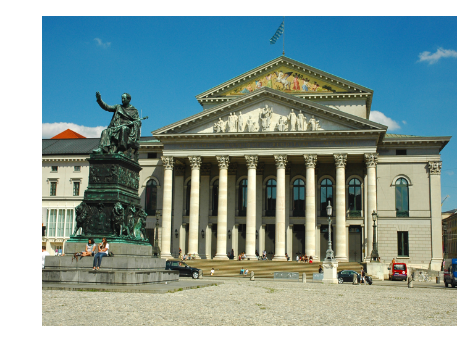

In [154]:
# acquire an image to make some tests

def img_path(img_id):
    return osp.join(IMG_PATH, '{}.png'.format(img_id))

sample = ndimage.imread(img_path(6))
plt.imshow(sample)
plt.axis('off')

In [155]:
sample.shape

(504, 672, 3)

All images (stored in `path/to/repo/img/`) are of shape **504x672**. We can thus split them into **9x12** grids of equal squares of size **56**. The following shows the grid :

(0.0, 672.0, 504.0, 0.0)

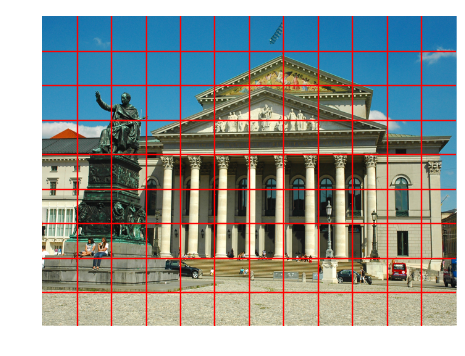

In [156]:
plt.imshow(sample)

for i in range(1,12):
    plt.plot([56*i,56*i],[0,504], 'r-')
for i in range(1,9):
    plt.plot([0,672], [56*i,56*i], 'r-')
    
plt.axis([0,672,504,0])
plt.axis('off')

To manipulate pieces of the jigsaw puzzle, we need to store them as separate images. The split is defined below :

In [157]:
# define a splitter function
def split_img(img, size=56):
    pieces = []
    vshape = img.shape[0]
    hshape = img.shape[1]
    
    if vshape%size != 0 or hshape%size != 0:
        raise 'Problem with image shape and patch size'
    
    for hb in range(0,hshape,size):
        #b for begin, e for end
        he = hb + size
        for vb in range(0,vshape,size):
            ve = vb + size
            pieces.append(img[vb:ve, hb:he, :])
            
    return pieces

In [158]:
pieces = split_img(sample)
len(pieces)

108

So the puzzle is correctly made out of 108 (9x12) pieces, as in the aforementioned article. However, the images are still ordered :

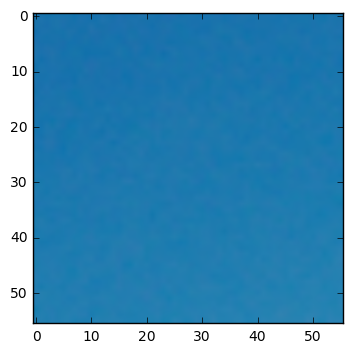

In [159]:
plt.imshow(pieces[0]) # should be top left corner, hence blue sky

Let's add some shuffling :

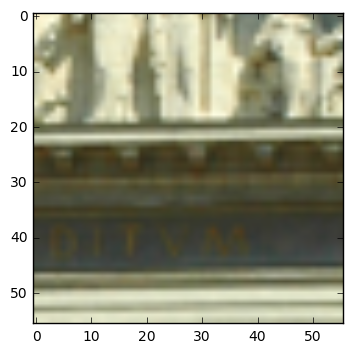

In [54]:
np.random.shuffle(pieces)
plt.imshow(pieces[0]) #shouldn't be (probably) blue sky anymore

## Graph manipulation

What's a graph in our context ?

+ A set $(V, E, a)$
    
+ $V$ is a set of vertices, i.e. $v_j = (p_i, q_i)$ 
    + with $p_i$ being a patch index ($p_i = i \in \{0, ..., 108\}$)
    + and $q_i$ being a grid location index ($q_i = i \in \{0, ..., 108\}$)

+ $E$ is a set of edges (couples of $(v_i, v_j)$)

+ $a$ is the weight function

However, the article tells us the common usage is to represent the graph as an affinity matrix $A = (a_{ij})$ such that :

+ If $(v_i, v_j) \in E$ (that is, the two potential pairs are consistent with the graph rules), we have $a_{ij} = a(v_i, v_j)$
+ Else, $a_{ij} = 0$

In our case then, $A$ is of size $108^2$ x $108^2$, though is sparse : a simple rule "if $(p_i, q_j)$ in the selected vertices, then $\forall k$ in the remaining locations, $(p_i, q_k)$ cannot be selected" means that only one in 108 edges $a_{ij}$ may have a non-zero value.

In [160]:
size = 108**2
A = np.zeros((size,size))

In [161]:
mem = A.nbytes
ngig = int(mem/(1024**3))
nmeg = mem/(1024**2) - ngig*1024
print("A is of size {}GB and {}MB".format(ngig, round(nmeg,2)))

A is of size 1GB and 13.97MB


Here we can see that $A$ takes up a lot of RAM (1GB), and making use of sparse implementation would be smart. However, we have sufficient memory available (>10GB), so we won't mind this aspect.

For the same reasons, we will first compute all dissimilarities between patches along each of their 4 edges, in a matrix $D$.

In [163]:
def dissimilarity(img1, img2, side):
    # we compute dissimilarity between
    # two puzzle pieces along the first one's `side`
    # side can be 't', 'b', 'l' or 'r'
    if side == 't':
        vec1, vec2 = img1[0, :], img2[-1, :]
    elif side == 'b':
        vec1, vec2 = img1[-1, :], img2[0, :]
    elif side == 'l':
        vec1, vec2 = img1[:, 0], img2[-1, :]
    elif side == 'r':
        vec1, vec2 = img1[:, -1], img2[:, 0]
    else:
        raise Exception('side can only be "t","b","r" or "l". "{}" was given.'.format(side))
    
    diffs = (vec1-vec2).astype(np.uint32) #was using uint8 for imgs, 
                            # but not large enough for squared vals
    return np.sum(np.square(diffs))

Now let's check some of its properties and validate its behavior.

In [164]:
def assemble(img1,img2,side):
    l = img1.shape[0]
    if side == 't':
        assembly = np.zeros((2*l,l,3), dtype=np.uint8)
        assembly[l:,:] = img1
        assembly[:l,:] = img2
    elif side == 'b':
        assembly = np.zeros((2*l,l,3), dtype=np.uint8)
        assembly[:l,:] = img1
        assembly[l:,:] = img2
    elif side == 'l':
        assembly = np.zeros((l,2*l,3), dtype=np.uint8)
        assembly[:,l:] = img1
        assembly[:,:l] = img2
    elif side == 'r':
        assembly = np.zeros((l,2*l,3), dtype=np.uint8)
        assembly[:,:l] = img1
        assembly[:,l:] = img2
        
    return assembly
    
def check_diss(i,j,w,c):
    wrong = dissimilarity(pieces[i], pieces[j], w)
    correct = dissimilarity(pieces[i], pieces[j], c)
    
    plt.figure(1)
    plt.subplot(121)
    plt.imshow(assemble(pieces[i], pieces[j], w))
    plt.subplot(122)
    plt.imshow(assemble(pieces[i], pieces[j], c))
    plt.show()
    
    print('Wrong side : {}'.format(wrong))
    print('Correct side : {}'.format(correct))
    print('-------')
    print('Ratio w/c: {}'.format(wrong/correct))

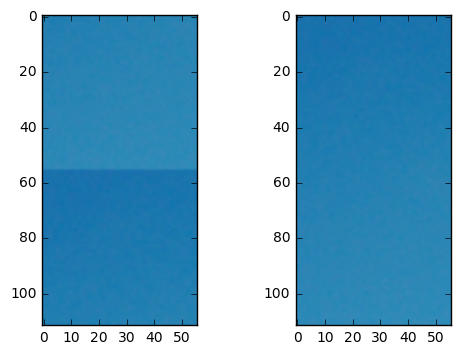

Wrong side : 9442904
Correct side : 3860648
-------
Ratio w/c: 2.4459375731742443


In [165]:
check_diss(0,1,'t','b')

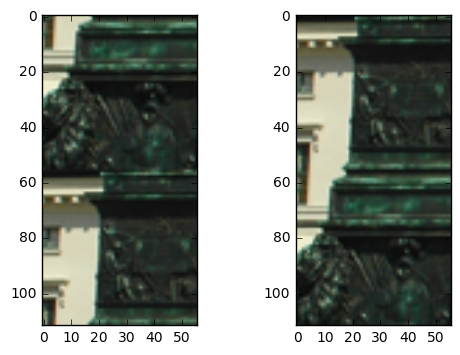

Wrong side : 6063916
Correct side : 1515713
-------
Ratio w/c: 4.000701979860303


In [166]:
check_diss(13,14,'t','b')

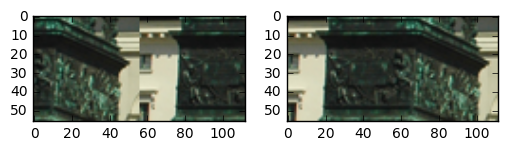

Wrong side : 3179941
Correct side : 5341172
-------
Ratio w/c: 0.5953639014059087


In [167]:
check_diss(13,22,'l','r')

The results feel correct though imperfect... However, the formula is the one presented in the paper. $$D(p_i,p_j,LR) = \sum_{k=1}^{56} \sum_{c=1}^3 (z_j(k,lastcol,c) - z_i(k,firstcol,c))^2$$

I believe we could improve the results by improving this dissimilarity measure. We could maybe use a convolutional net to predict the probability as a $[0,1]^4$ vector, crushing the need to transform the dissimilarity into a probability (wouldn't be less computationally intensive though).

Now let's compute dissimilarity values for all ternaries (piece 1, piece 2, side) into a $D$ matrix.

In [168]:
def D_matrix(elems):
    n = len(elems)
    D = np.zeros((n,n,4), dtype=np.uint32)
    for i in range(n):
        for j in range(n):
            k = 0
            for side in ['t','b','l','r']:
                D[i,j,k] = dissimilarity(elems[i], elems[j], side)
                k += 1
    return D

In [169]:
D = D_matrix(pieces)

In [170]:
D.nbytes # way lighter than A

186624

In [171]:
D.shape[1]

108

In [172]:
def get_deltas(D):
    deltas = np.zeros(D.shape[0])
    
    for i in range(D.shape[0]):
        min1 = min2 = np.max(D)
        
        for j in range(D.shape[1]):
            for k in range(4):
                if D[i,j,k] < min1:
                    min2 = min1
                    min1 = D[i,j,k]
                elif D[i,j,k] < min2:
                    min2 = D[i,j,k]
        
        deltas[i] = min2 - min1
    
    return deltas

In [173]:
deltas = get_deltas(D)

In [174]:
####

# How we aim to represent A

#         p_0,q_0 -- p_0,q_m | p_1,q_0 ... p_m,q_0 -- p_m,q_m
# p_0,q_0
#    |
# p_0,q_m
# -------
#   ...
# -------
# p_m,q_0
#    |
# p_m,q_m

####

The rules :

+ `a( (p_i, q_j), (p_i, q_k) ) = 0` if `j != k` else, compute value (see below)
+ `a( (p_j, q_i), (p_k, q_i) ) = 0` if `j != k` else, compute value (see below)
+ The last rule is about the adjacency of board locations. We know about them, hence we have specific clues to fill in $A$

After thinking again, this $A$ matrix is not of any use once we have $D$ for puzzle solving. Adjacency between board locations $q$ is easy to check.

In [175]:
def to_affinity(D):
    #and beyond
    A = np.zeros(D.shape, dtype=np.float32)
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            for k in range(4):
                A[i,j,k] = np.exp(-0.5 * D[i,j,k] / deltas[i])
    
    return A

In [176]:
A=to_affinity(D)

In [190]:
np.mean(A)

0.0035565828

In [191]:
np.max(A)

0.96061248

In [192]:
np.min(A)

0.0

## The algorithm

We start by defining a particle class, then we will define the algorithm class to solve the puzzle (and later add timer functions and other descriptive statistics).

In [239]:
class Particle:
    def __init__(self, past = None, new = None, size = (9,12), A = None, gamma = 0.4, verbose = False):
        #if new particle
        #    Particle(size, A, gamma)
        #if follower
        #    Particle(past, new)
        if past is None:
            self.state = 1
            self.weight = 1
            self.selected = [(0,0)] #first piece into top left corner
            self.rem_locs, self.rem_pieces = set(range(1,108)), set(range(1,108))
            self.size = size
            self.max_state = size[0] * size[1]
            self.A = A
            self.gamma = gamma
        else:
            from copy import copy
            # copy attributes
            self.weight = copy(past.weight)
            self.selected = copy(past.selected)
            self.rem_locs, self.rem_pieces = copy(past.rem_locs), copy(past.rem_pieces)
            self.size = copy(past.size)
            self.max_state = self.size[0] * self.size[1]
            self.A = copy(past.A)
            self.gamma = copy(past.gamma)
            self.state = copy(past.state) + 1
            
            # update with new item
            if verbose: print('weight before reweight : {}'.format(self.weight))
            self.weight = self.reweight(new)
            if verbose: print('weight after reweight : {}'.format(self.weight))
            
            self.selected.append(new)
            if verbose: print('update selector : {}'.format(new))
            
            self.rem_locs.remove(new[1])
            self.rem_pieces.remove(new[0])
    
    def get_neighborhood(self, nl_dic):
        #get all potential pairs (piece, location)
        nbh = []
        
        for v in self.selected:
            for loc in self.rem_locs.intersection(nl_dic[v[1]]):
                for piece in self.rem_pieces:
                    nbh.append((piece, loc))
        
        return nbh
    
    def reweight(self, new):
        #use new proposal to weight the particle
        to_check = self.near_locs(new[1])
        val = 0
        corr = { #0:top, 1:bottom, 2:left, 3:right
            1: 1, -1: 0,
            self.size[0]: 3, 
            - self.size[0]: 2
        }
        for loc in to_check:
            if loc in self.rem_locs:
                #still unexplored
                continue
            move = loc - new[1]
            side = corr[move]
            val += self.A[self.get_piece(loc), new[0], side]
                
        return self.weight * np.exp(2 * val / self.gamma)
    
    def near_locs(self, q):
        #compute all potential adjacent board locations
        moves = []
        nr = self.size[0]
        row, col = q%nr, q//nr
        
        if row == 0:
            moves += [1]
        elif row == nr - 1:
            moves += [-1]
        else:
            moves += [1,-1]
        
        if col == 0:
            moves += [nr]
        elif col == self.size[1] - 1:
            moves += [-nr]
        else:
            moves += [nr, -nr]
            
        return [q+m for m in moves]
    
    def move_to_side(self, move):
        corr = { #0:top, 1:bottom, 2:left, 3:right
            1: 1, -1: 0,
            self.size[0]: 3, 
            - self.size[0]: 2
        }
        return corr[move]
    
    def get_piece(self, loc):
        for v in self.selected:
            if v[1] == loc:
                return v[0]
        raise Exception('Location {} is not yet filled.'.format(loc))

In [240]:
class PuzzleSMC:
    def __init__(self, image_id, n_particles,
                 patch_size=56,
                 gamma=0.4,
                 run=False):
        print('Initializing puzzle...')
        
        # load image and split into pieces (get grid shape too)
        print('\tLoading img {}'.format(image_id))
        self.pieces, self.shape = self.img_to_pieces(image_id, patch_size)
        
        # store affinities
        print('\t\tOK\n\tComputing graph edges weights...')
        self.A = self.get_aff(self.pieces)
        self.nl_dic = self.compute_near_locs()
        
        # init particles
        print('\t\tOK\n\tInitializing particles...')
        self.n_particles = n_particles
        self.particles = [
            Particle(A=self.A,
                     gamma=gamma,
                     size=self.shape
            )
        ]
        self.sim_ix = [0 for k in range(self.n_particles)]
            
        # run loop
        if run:
            print('\t\tOK\n\n-- RUN --\n')
            self.result = self.run()
        
    def run(self):
        last_weights = [0]
        for state in range(1, self.max_state):
            if state%5 == 0:
                print('\tstate : {}/{}'.format(state, self.max_state))
                
            try:
                temp = self.propose()
                weights = self.evaluate(temp)
                self.resample(temp, weights)
                assert last_weights != weights
                last_weights = weights
            except:
                print('state : ', state)
                print('min-max weight : ', np.min(weights), np.max(weights))
                print('n_unique : ', len(self.particles))
                print('n_followers : ', len(temp))
                raise
        
        self.result = self.get_best()
        return self.result
    
    def propose(self):
        temp = []
        
        for i in range(len(self.particles)):
            part = self.particles[i]
            fols = part.get_neighborhood(self.nl_dic)
            for fol in fols:
                temp.append((i,fol))
                
        return temp
    
    def evaluate(self, temp):
        # normalize weights to sample from
        weights = []
        last_i = -1
        
        for i, fol in temp:
            if i != last_i:
                part = self.particles[i]
                last_i = i
                
            w = part.reweight(fol)
            
            #self.sim_ix.count(i) is the number of particles
            # in the equivalence class
            weights.append(w*self.sim_ix.count(i))
        
        div = np.sum(weights)
        return [w / div for w in weights]
    
    def resample(self, temp, weights):
        # sample self.n_particles from weights
        # and update self.particles
        sampled_ix = np.random.choice(
            list(range(len(temp))), 
            size=self.n_particles,
            p=weights
        )
        
        rem_uniques = set(sampled_ix)
        unique_particles = []
        unique_ix, sim_ix = 0, []
        
        for ix in sampled_ix:
            if ix in rem_uniques:
                i, fol = temp[ix]
                past = self.particles[i]
                
                unique_particles.append(
                    Particle(
                        past = past,
                        new = fol
                    )
                )
                unique_ix += 1
                rem_uniques.remove(ix)
            
            sim_ix.append(unique_ix)
        
        self.particles = unique_particles
        self.sim_ix = sim_ix
    
    def get_best(self):
        best = None
        
        for part in self.particles:
            if best is None:
                best = part
                continue
            if part.weight > best.weight:
                best = part
                
        return best
        
    def compute_near_locs(self):
        # to use only once and limit useless computations
        nl_dic = {}

        for q in range(self.max_state):
            nl_dic[q] = self.near_locs(q)
        
        return nl_dic
    
    def near_locs(self, q):
        #compute all potential adjacent board locations
        moves = []
        nr = self.shape[0]
        row, col = q%nr, q//nr
        
        if row == 0:
            moves += [1]
        elif row == nr - 1:
            moves += [-1]
        else:
            moves += [1,-1]
        
        if col == 0:
            moves += [nr]
        elif col == self.shape[1] - 1:
            moves += [-nr]
        else:
            moves += [nr, -nr]
            
        return [q+m for m in moves]
    
    def img_to_pieces(self, img_id, size):
        #we always give the first piece in the top left corner as a starter
        img_path = osp.join(IMG_PATH, '{}.png'.format(img_id))
        img = ndimage.imread(img_path)
        
        pieces = []
        vshape = img.shape[0]
        hshape = img.shape[1]

        if vshape%size != 0 or hshape%size != 0:
            msg = 'Problem with image shape ({}) and patch size ({})'.format(img.shape,size)
            raise Exception(msg)
            
        for hb in range(0,hshape,size):
            #b for begin, e for end
            he = hb + size
            for vb in range(0,vshape,size):
                ve = vb + size
                pieces.append(img[vb:ve, hb:he, :])
        
        first, other = [pieces[0]], pieces[1:]
        np.random.shuffle(other)
        
        pieces = first + other
        shape = (vshape//size, hshape//size)
        
        # we store the number of puzzle pieces
        self.max_state = len(pieces)
        
        return pieces, shape
    
    def get_aff(self, pieces):
        try:
            D = self.D_matrix(pieces)
        except:
            print('len(pieces)')
            print(len(pieces))
            raise
        A = np.zeros(D.shape, dtype=np.float32) #can be small, but enough
        for i in range(D.shape[0]):
            for j in range(D.shape[1]):
                for k in range(4):
                    A[i,j,k] = np.exp(-0.5 * D[i,j,k] / deltas[i]**2)

        return A
        
    def dissimilarity(self, img1, img2, side):
        # we compute dissimilarity between
        # two puzzle pieces along the first one's `side`
        # side can be 't', 'b', 'l' or 'r'
        try:
            if side == 't':
                vec1, vec2 = img1[0, :], img2[-1, :]
            elif side == 'b':
                vec1, vec2 = img1[-1, :], img2[0, :]
            elif side == 'l':
                vec1, vec2 = img1[:, 0], img2[-1, :]
            elif side == 'r':
                vec1, vec2 = img1[:, -1], img2[:, 0]
            else:
                raise Exception('side can only be "t","b","r" or "l". "{}" was given.'.format(side))
        except:
            print(img2.shape)
            raise
                
        diffs = (vec1-vec2).astype(np.uint32) #was using uint8 for imgs, 
                                # but not large enough for squared vals
        return np.sum(np.square(diffs))
    
    def D_matrix(self, elems):
        n = len(elems)
        D = np.zeros((n,n,4), dtype=np.uint32)
        for i in range(n):
            for j in range(n):
                k = 0
                for side in ['t','b','l','r']:
                    try:
                        D[i,j,k] = self.dissimilarity(elems[i], elems[j], side)
                    except:
                        print(i)
                        plt.imshow(elems[i])
                        print(j)
                        print(elems[j])
                        raise
                    k += 1
        return D

In [250]:
puzzle = PuzzleSMC(6,50, gamma=0.2)

Initializing puzzle...
	Loading img 6
		OK
	Computing graph edges weights...
		OK
	Initializing particles...


In [233]:
temp = puzzle.A

In [251]:
puzzle.run()

	state : 5/108
	state : 10/108
	state : 15/108
	state : 20/108
	state : 25/108
	state : 30/108
	state : 35/108
	state : 40/108
state :  41
min-max weight :  0.0 0.0
n_unique :  50
n_followers :  45158


ValueError: probabilities do not sum to 1

In [238]:
108**2*49

571536

In [ ]:
a = Particle(
    A = A_test,
    gamma = 0.4,
    verbose = True,
    
)

In [213]:
a.reweight((51,1))

1.0

In [182]:
from time import time
t = time()
puzzle.run()
print(time() - t)

temp :  [(0, (0, 1)), (0, (1, 1)), (0, (2, 1)), (0, (3, 1)), (0, (4, 1)), (0, (5, 1)), (0, (6, 1)), (0, (7, 1)), (0, (8, 1)), (0, (9, 1)), (0, (10, 1)), (0, (11, 1)), (0, (12, 1)), (0, (13, 1)), (0, (14, 1)), (0, (15, 1)), (0, (16, 1)), (0, (17, 1)), (0, (18, 1)), (0, (19, 1)), (0, (20, 1)), (0, (21, 1)), (0, (22, 1)), (0, (23, 1)), (0, (24, 1)), (0, (25, 1)), (0, (26, 1)), (0, (27, 1)), (0, (28, 1)), (0, (29, 1)), (0, (30, 1)), (0, (31, 1)), (0, (32, 1)), (0, (33, 1)), (0, (34, 1)), (0, (35, 1)), (0, (36, 1)), (0, (37, 1)), (0, (38, 1)), (0, (39, 1)), (0, (40, 1)), (0, (41, 1)), (0, (42, 1)), (0, (43, 1)), (0, (44, 1)), (0, (45, 1)), (0, (46, 1)), (0, (47, 1)), (0, (48, 1)), (0, (49, 1)), (0, (50, 1)), (0, (51, 1)), (0, (52, 1)), (0, (53, 1)), (0, (54, 1)), (0, (55, 1)), (0, (56, 1)), (0, (57, 1)), (0, (58, 1)), (0, (59, 1)), (0, (60, 1)), (0, (61, 1)), (0, (62, 1)), (0, (63, 1)), (0, (64, 1)), (0, (65, 1)), (0, (66, 1)), (0, (67, 1)), (0, (68, 1)), (0, (69, 1)), (0, (70, 1)), (0, (71

NameError: name 'rem_locs' is not defined

In [245]:
def assemble_pieces(pieces):
    full_pic = np.zeros((504, 672, 3), dtype=np.uint8)
    size = 56
    for i in range(len(pieces)):
        h_ix = (i//9) * size
        v_ix = (i%9) * size

        full_pic[v_ix:v_ix+size, h_ix:h_ix+size, :] = pieces[i]
    
    return full_pic

Let's show the initial order of pieces (we select all (i,i) vertices) :

In [246]:
pieces = puzzle.pieces
len(pieces)

108

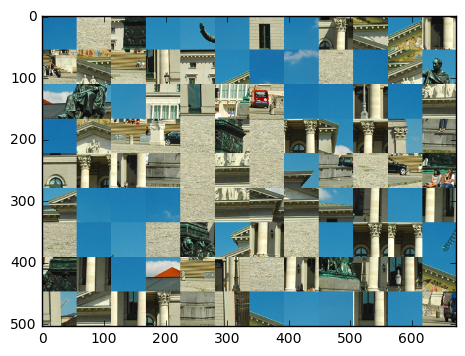

In [247]:
initial = assemble_pieces(pieces)
plt.imshow(initial)

Then the best Particle from the algorithm :

In [248]:
res = puzzle.result.selected

locations = [el[1] for el in res]
sorted_locix = np.argsort(locations)

sorted_pieces = []
for ix in sorted_locix:
    sorted_pieces.append(pieces[res[ix][0]])

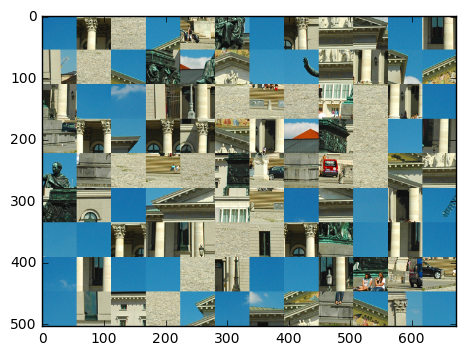

In [249]:
sorted_pic = assemble_pieces(sorted_pieces)
plt.imshow(sorted_pic)

Poor results... We'll try to improve the algorithm complexity in order to be able to run much more particles.

An idea would be to aggregate the potential redundant followers from each of the current particles instead of storing them separately. This would then cap the size of the temporary list of followers to 108², instead of 108² x N.

... after a 1H50 run with 800 particles, not much improvement. Something is wrong. The aggregation probably doesn't take account for proper weighting.

In [37]:
import pickle

pickle.dump(puzzle, open('puzzle_img6_800', 'wb'))

In [41]:
def show_part_state(pieces, state):
    full_pic = np.zeros((504, 672, 3), dtype=np.uint8)
    size = 56
    
    for p, q in state:
        h_ix = (q//9) * size
        v_ix = (q%9) * size

        full_pic[v_ix:v_ix+size, h_ix:h_ix+size, :] = pieces[p]
    
    return full_pic

In [43]:
def iter_part(pieces, selected):
    for i in range(len(selected)):
        pic = show_part_state(pieces, selected[:i])
        plt.imshow(pic)
        yield(i)

In [44]:
a = iter_part(pieces, res)

45

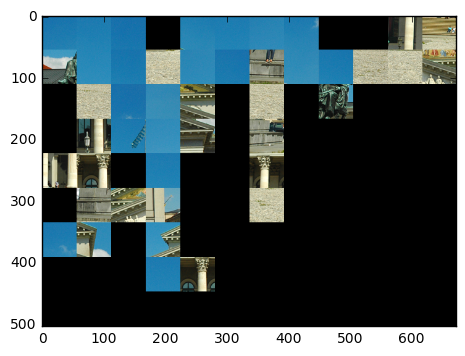

In [90]:
next(a)

## Optimizing the solver

In order to reduce computation time, we want to introduce two ideas :

1. There may be **identical** particles at time step **t**
2. We can normalize the weights to sample from the obtained **equivalence classes**

For example, if we store the "fake" particles as a list of indexes pointing to a set of unique particles, at the first step we have :

+ `unique_particles = [ Particle( (0,0) ) ]`
+ `sim_ix = [ 0 for k in range(n_particles) ]`

This way we can keep the advantages of the Particle class without overflowing the memory. To update these lists at each time step, we need to formalize the substeps :

+ **Propose**
    + for each unique particle **i**, we get its followers **(fol)**
    + into a big global list : `[ (i, fol), ... ]`

+ **Evaluate**
    + for each couple `(i, fol)`, get its weight (without generating another Particle object)
    + to normalize the weights, we simply multiply each by the number of particles in the equivalence class **i**, then divide by their total sum

+ **Resample**
    + sample `n_particles` couples `(i, fol)` according to their normalized weights
    + generate the unique particles and the similarity index after the sampling
    
From this adaptation, particles are **identical** if they have the exact same history (even if they select the same vertices, the path may be different).